# **Time series forecasting with ARIMA**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [4]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=2ac957556e1f386f575bb9c150f2a41614d8a8aca71279f5b99101789b0d6465
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
path = "/content/drive/MyDrive/Classification/energy.csv"
energy = pd.read_csv(path, index_col=False)
energy.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


In [6]:

energy.index

RangeIndex(start=0, stop=26304, step=1)

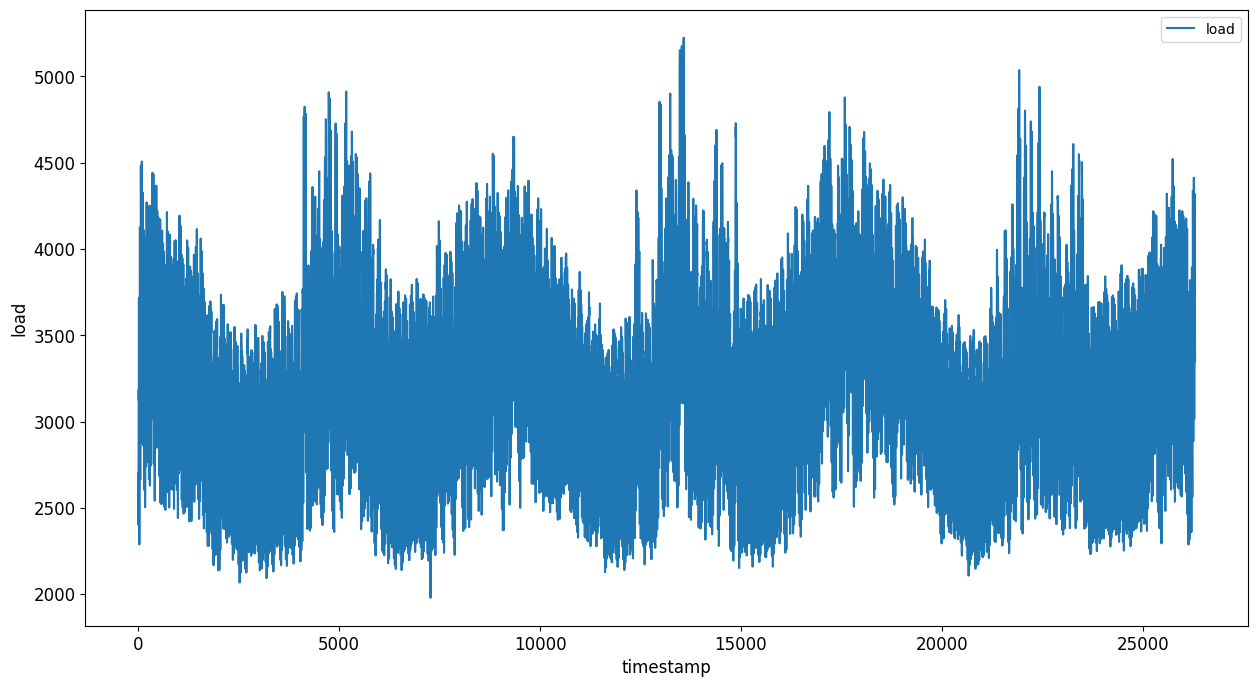

In [7]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

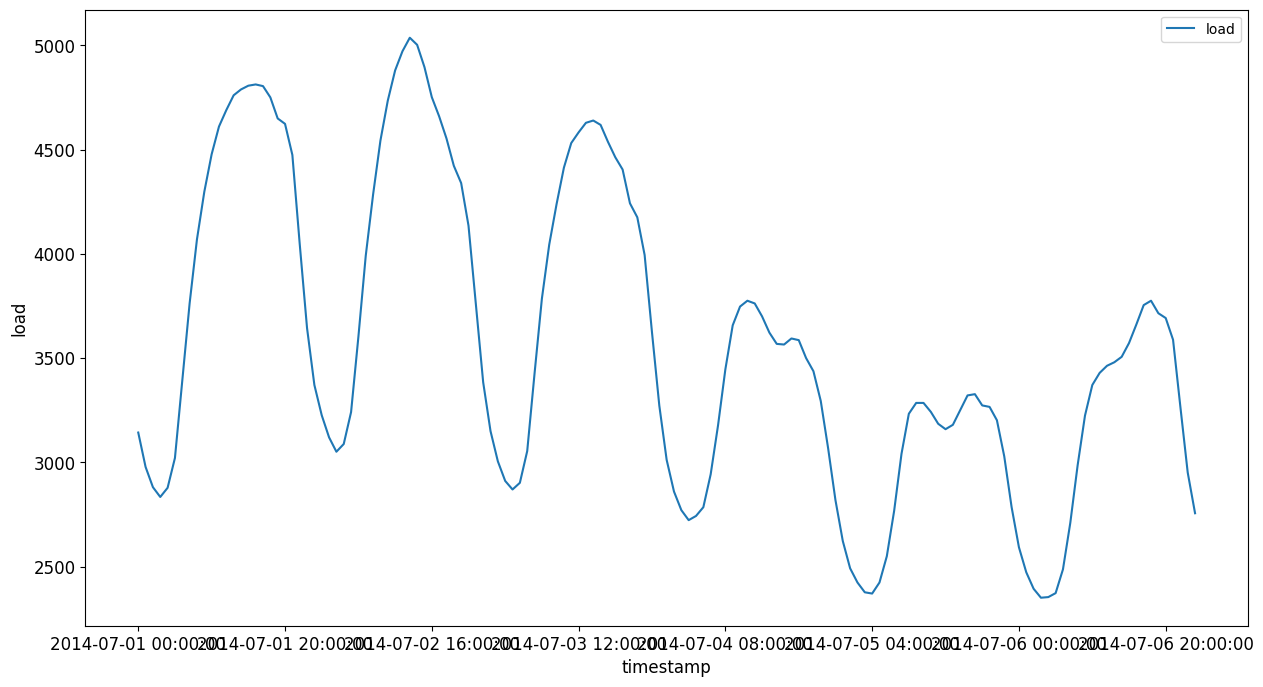

In [21]:
# plot the first week of July 2014,
energy = energy.set_index('timestamp').sort_index()
energy["2014-07-01 00:00:00":"2014-07-07 00:00:00"].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
pip install statsmodels

In [23]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
#from utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

**Create training and testing datasets**

In [24]:
#Allocate a two-month period from September 1 to October 31, 2014 to the training set. The test set will include the two-month period of November 1 to December 31, 2014:
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

In [25]:
energy.index

Index(['2012-01-01 00:00:00', '2012-01-01 01:00:00', '2012-01-01 02:00:00',
       '2012-01-01 03:00:00', '2012-01-01 04:00:00', '2012-01-01 05:00:00',
       '2012-01-01 06:00:00', '2012-01-01 07:00:00', '2012-01-01 08:00:00',
       '2012-01-01 09:00:00',
       ...
       '2014-12-31 14:00:00', '2014-12-31 15:00:00', '2014-12-31 16:00:00',
       '2014-12-31 17:00:00', '2014-12-31 18:00:00', '2014-12-31 19:00:00',
       '2014-12-31 20:00:00', '2014-12-31 21:00:00', '2014-12-31 22:00:00',
       '2014-12-31 23:00:00'],
      dtype='object', name='timestamp', length=26304)

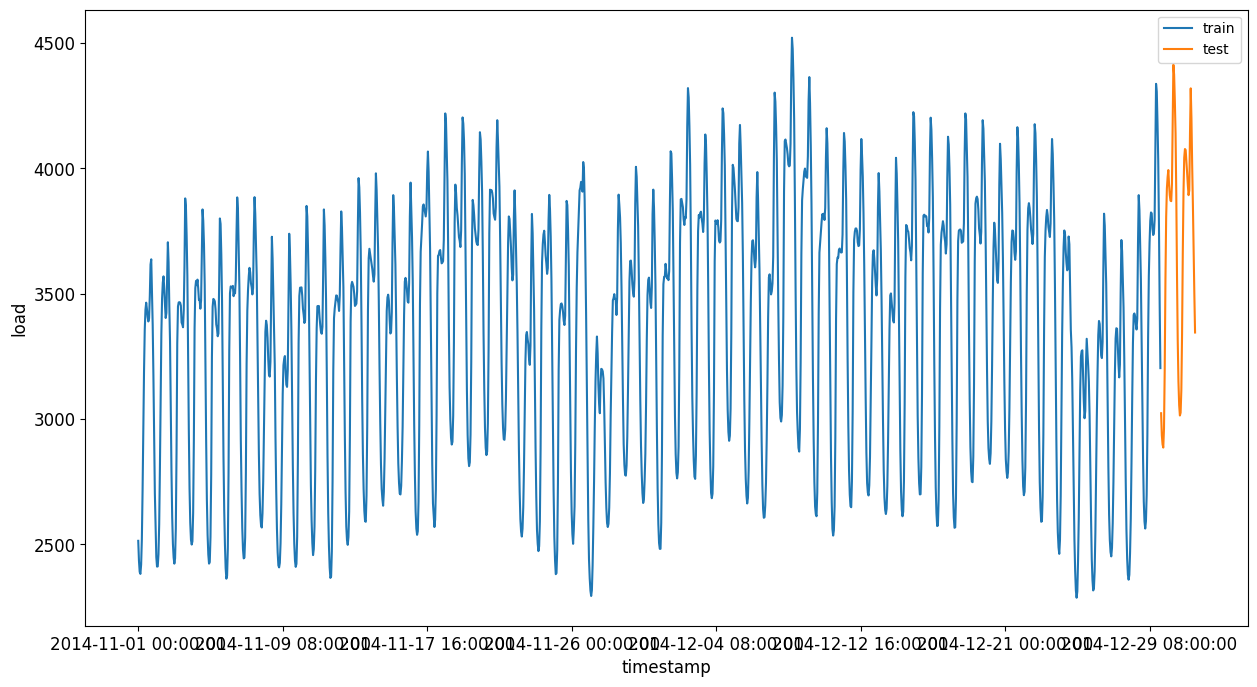

In [26]:
#Visualize the differences:
energy[(energy.index< test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'})\
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

**Prepare the data for training**

In [27]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [28]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40


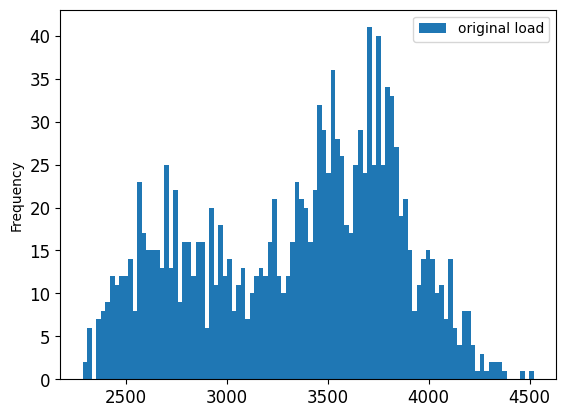

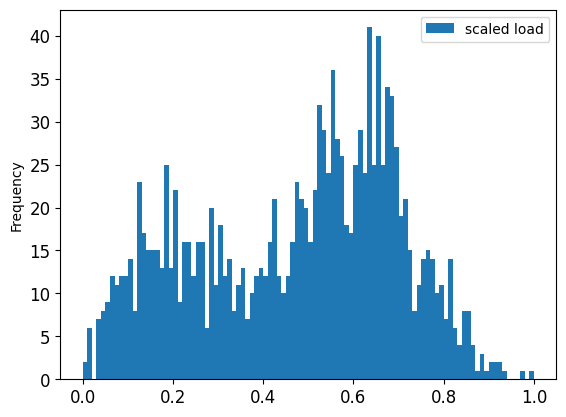

In [29]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [30]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


# **Implement ARIMA**

In [31]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [32]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.235
Date:                            Wed, 25 Sep 2024   AIC                          -6942.469
Time:                                    11:33:35   BIC                          -6911.042
Sample:                                11-01-2014   HQIC                         -6930.717
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8397      0.016     52.251      0.000       0.808       0.871
ar.L2         -0.5209      0.034   

**Evaluate your model**

In [36]:

test.index = pd.to_datetime(test.index)
test_shifted = test.copy()
for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
timestamp,,,,
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


In [37]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.73097582811101

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[1:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

**Check model accuracy**

In [ ]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

In [ ]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

In [ ]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

In [ ]:
 if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

**Time Series Forecasting with Support Vector Regressor**

In [ ]:
#Prepare the data for training
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [ ]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

In [ ]:
test['load'] = scaler.transform(test)

In [ ]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [ ]:
timesteps=5

In [ ]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1412, 5)

In [ ]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(44, 5)

In [ ]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1412, 4) (1412, 1)
(44, 4) (44, 1)


# **Implement SVR**

In [ ]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [ ]:
model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [ ]:
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1412, 1) (44, 1)


**Evaluate your model**

In [ ]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1412 44


In [ ]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1412 44


In [ ]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1412 44


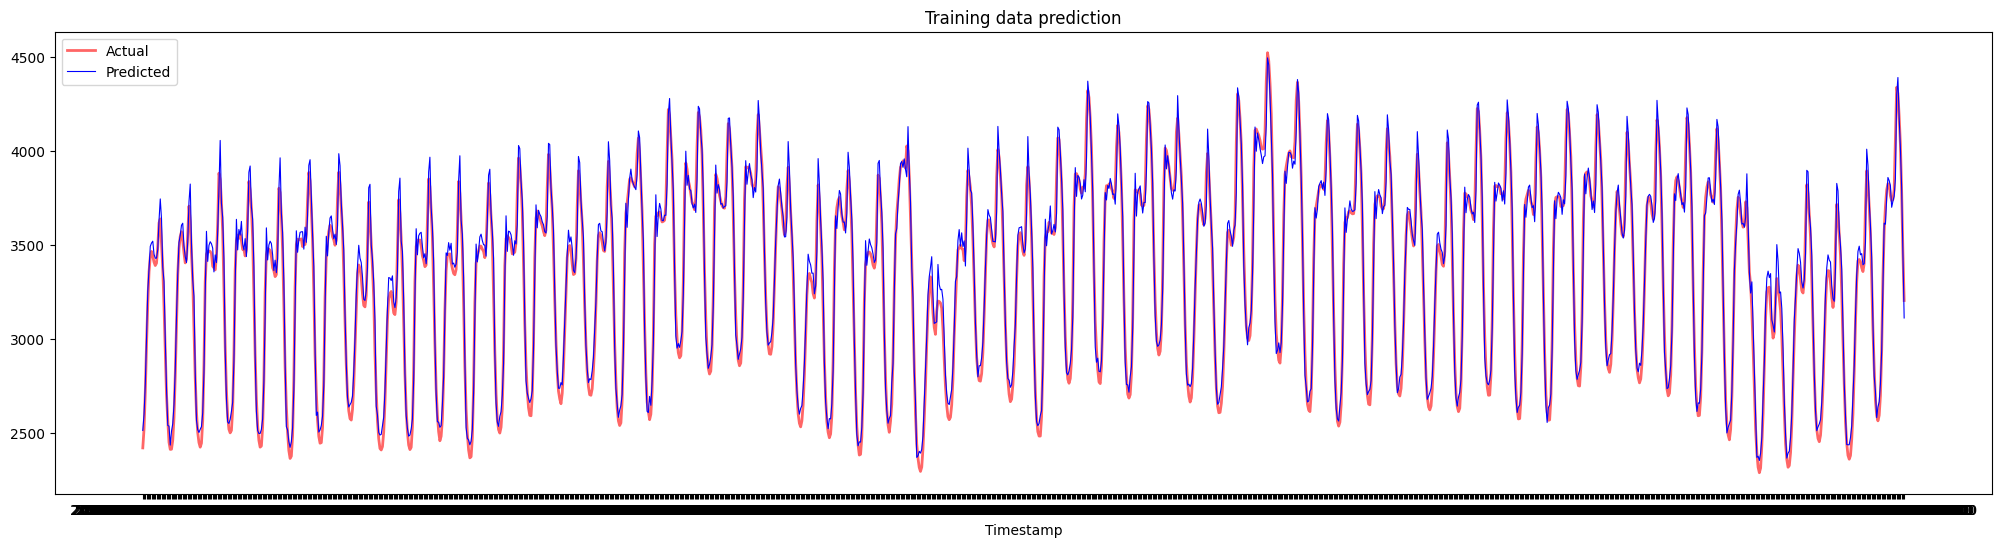

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [ ]:
print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

NameError: name 'mape' is not defined

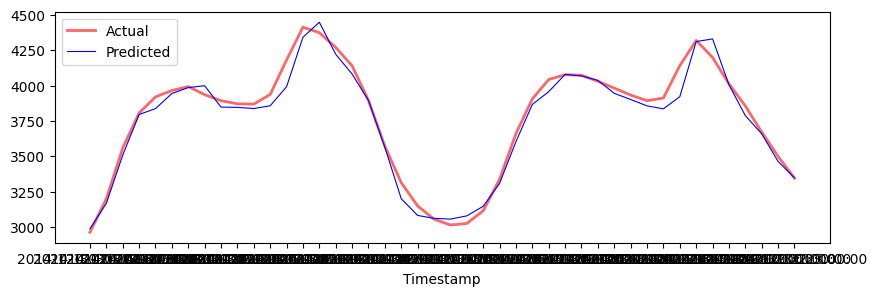

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [ ]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

In [ ]:
# Extracting load values as numpy array
data = energy.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

In [ ]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [ ]:
print('MAPE: ', mape(Y_pred, Y)*100, '%')